# Эксперименты с шумом


 In-sample MSE: 5.39280726819
Population MSE: 5.3731189914


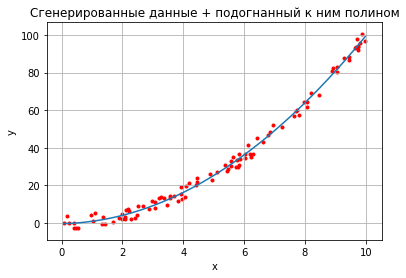

In [61]:
# General:
import numpy as np
# Graphics:
import seaborn as sns
from matplotlib import pyplot as plt
# Mathematics:
from random import random, randint, uniform
import numpy.polynomial.polynomial as poly
# ML:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


POPULATION_SIZE = 100000
SAMPLE_SIZE = 100
POLY_DEGREE = 2
NOISE       = 4


def experiment(population_size, sample_size, poly_degree, noise_magnitude, show_result=True):
    # 1. Сгенерируем данные, порождённые параболой с некоторым шумом:
    X = [random()*10 for _ in range(population_size)]
    y = [(each**2) + uniform(-1, 1)*noise_magnitude for each in X]
    
    # 2. Вытянем выборку заданного объёма:
    _, X_sample, _, y_sample = train_test_split(X, y, test_size=sample_size)

    # 3. Произведём подгонку к данным полинома заданной степени:
    coefs = poly.polyfit(X_sample, y_sample, poly_degree)
    fit = poly.Polynomial(coefs)
    
    # 4. Отчитаемся о величине ошибки на тренировочной выборке и на популяции:
    # ----- E_in:
    y_pred = [fit(each) for each in X_sample]
    E_in = mean_squared_error(y_sample, y_pred)
    # ----- E_population:
    y_pred = [fit(each) for each in X]
    E_pop = mean_squared_error(y, y_pred)
    if show_result:
        print('\n In-sample MSE:', E_in)
        print('Population MSE:'  , E_pop)
    
    # 5. Отобразим результат графически:
    if show_result:
        x_coords = np.linspace(min(X_sample), max(X_sample), num=len(X_sample)*10)
        plt.clf()
        plt.plot(x_coords, fit(x_coords))
        plt.scatter(X_sample, y_sample, c='r', marker='.')
        plt.title('Сгенерированные данные + подогнанный к ним полином')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.show()
    return E_in, E_pop


experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

## 1. Наблюдение первое - о переподгонке и шуме
Из лекции профессора Абу-Мостафа о переподгонке следует, что виновником переподгонки является шум. При этом даже в случае отсутствия стохастического шума переподгонка очень даже возможна - при наличии детерминистского шума:

$$\mathrm{E}_{\mathcal{D}}[E_{out}(g^{\mathcal{D}}(x))] = \underbrace{ \mathrm{E}_{\mathcal{D}}[\mathrm{E}_x[(g^{\mathcal{D}}(x)-\bar{g}(x))^2]] }_{variance} \quad + \underbrace{\mathrm{E}_{\mathsf{x}}[(\bar{g}(x)-f(x))^2]}_{bias,\space детерминистский \space шум} + \underbrace{ \mathrm{E}_{\epsilon, x}[(\epsilon(x))^2] }_{noise,\space стохастический\space шум}$$

Отсюда следует, что если свести весь шум к нулю, то ошибка будет равна дисперсии модели, которую, собственно, тоже можно ограничить. 

<br><br><center>**Опыт 1. Нулевой шум, ненулевая вариативность**</center>

Введём следующие условия:

**Условия:**
1. Стохастический шум равен нулю: $\forall{x}, \epsilon(x)=0$
2. Детерминистский шум равен нулю: $Complexity(g)=Complexity(f)$
3. Вариативность модели ненулевая; в данном случае (т.е. в случае с целевой функцией-параболой) объём выборки должен быть $\lt 3$.

**Ожидание:**

- Oжидается в целом небольшая MSE, обусловленная целиком дисперсией, присущей модели.

Поскольку объём тренировочной выборки составляет менее трёх точек, нельзя определить подгоняемую параболу однозначно. В самом деле, через одну или две точки можно провести бесконечное количество парабол.


 In-sample MSE: 4.03896783473e-28
Population MSE: 9.74872777815


/home/konstantin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RankWarning: The fit may be poorly conditioned


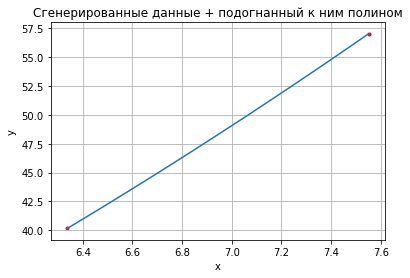

In [63]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 2 # < 3, данных для однозначного построения параболы недостаточно
POLY_DEGREE = 2 # нулевой детерминистский шум
NOISE       = 0 # нулевой стохастический  шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Прогнав данную функцию несколько раз, мы видим, что внесэмпловая ошибка чаще всего бывает очень большая, и скачет от 3 до 330 (за несколько прогонов). Для более точного отчёта мы можем прогнать алгоритм тысячу раз и записать результаты, отчитавшись о среднем значении ошибок:

In [64]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')

/home/konstantin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RankWarning: The fit may be poorly conditioned



MSE на тренировке
	  Среднее: 3.15062370492e-28
	Дисперсия: 2.00764015093e-55
	Min и max: 0.0 2.01948391737e-27

MSE на популяции
	  Среднее: 22.3375191419
	Дисперсия: 622.371569969
	Min и max: 3.63966137078 202.772723655 



**Результат:**
* MSE на тренировочной выборке ожидаемо получилась практически нулевой, в силу того, что подгонка полинома второй степени к двум точкам всегда будет идеальной.
* Однако на популяции MSE ожидаемо оказалась выше, с мощной дисперсией. Это обусловлено тем, что через две точки можно провести бесконечное количество парабол, и какая из них будет ближе к целевой функции - абсолютно неизвестно.

Теперь проведём такой же опыт, но уберём вариативность, задав как минимум 3 точки для тренировочного набора. Для точного задания параболы необходимо иметь как минимум 3 точки, через которые она проходит; а в силу того, что данные не имеют шума, эти 3 точки всегда будут лежать ровно на целевой параболе. Таким образом, ожидается, что подгонка всегда будет идеальной.

<br><br><center>**Опыт 2. Нулевой шум, нулевая вариативность**</center>

**Условия:**
1. Стохастический шум равен нулю: $\forall{x}, \epsilon(x)=0$
2. Детерминистский шум равен нулю: $\mathrm{Complexity}(g)=\mathrm{Complexity}(f)$
3. Вариативность модели нулевая; в данном случае (т.е. в случае с целевой функцией-параболой) объём выборки должен быть $=3$.

**Ожидание:**

- Oжидается нулевая MSE как на тренировке, так и на популяции. Это будет достигнуто за счёт нулевой вариативности, нулевого детерминистского и нулевого стохастического шума.


 In-sample MSE: 2.36658271566e-30
Population MSE: 2.47014840871e-29


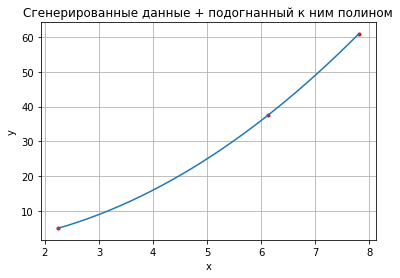

In [47]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # нулевая вариативность - достаточно данных для однозначного построения параболы
POLY_DEGREE = 2 # нулевой детерминистский шум
NOISE       = 0 # нулевой стохастический  шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Многократный прогон:

In [48]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 1.64122437798e-27
	Дисперсия: 1.8822093032e-53
	Min и max: 4.20725816118e-30 3.27654455504e-26

MSE на популяции
	  Среднее: 7.23051951361e-26
	Дисперсия: 2.79732379737e-49
	Min и max: 4.45962265005e-29 4.97824541428e-24 



**Результат:**
* MSE ожидаемо получилась нулевой, как на тренировочной выборке, так и на популяции.

В этом опыте мы фактически создали ситуацию, в которой для любых трёх точек, порождённых целевой функцией, наш ученик будет генерировать набор гипотез равный всего лишь одной гипотезе, которая совпадает с целевой функцией. Таким образом, симулировалась ситуация, в которой вариативность модели и её смещение равны нулю. В отсутствии шума, MSE ожидаемо получилась нулевой как на тренировке, так и на популяции.

Теперь возьмём эту ситуацию, но добавим немного стохастического шума.

<br><br><center>**Опыт 3. Ненулевой стохастический шум, ненулевая вариативность**</center>

**Условия:**
1. Стохастический шум не равен нулю: $epsilon(x) \neq 0$
2. Детерминистский шум равен нулю: $Complexity(g)=Complexity(f)$
3. Вариативность модели ненулевая. Даже при объёме обучающей выборки $>3$, парабола, подогнанная к этим трём точкам, будет отличаться от целевой функции, в силу наличия стохастического шума. По этой же причине каждый раз при генерации трёх точек варианты подогнанных парабол могут различаться. Таким образом, "средняя гипотеза" $\bar{g}(x)=\mathrm{E}_{\mathcal{D}}[g(x)]$ уже не будет единственной в наборе гипотез $\mathcal{H}$ ученика.

**Ожидание:**

- Oжидается нулевая MSE на обучающей выборке, в силу того, что можно идеально подогнать параболу к любым трём точкам. При этом энергия шума не имеет значения, однако если точек в эксперименте больше, чем 3, то MSE на обучающей выборке возрастёт.
- Ожидается высокая MSE на популяции, в силу того, что в данных присутствует шум. При этом энергия шума имеет значение (чем мощнее шум, тем больше ожидается MSE на популяции), и количество точек в эксперименте также имеет значение (чем больше точек дано, тем меньше ожидается  MSE на популяции). 



 In-sample MSE: 1.68316621811e-27
Population MSE: 56.4726587431


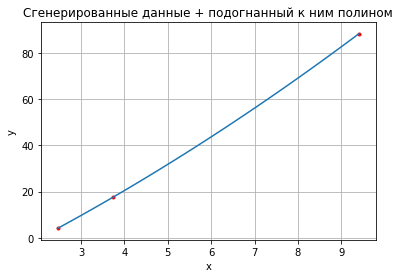

In [49]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # нулевая вариативность - достаточно данных для однозначного построения параболы
POLY_DEGREE = 2 # нулевой детерминистский  шум
NOISE       = 4 # ненулевой стохастический шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE);

Многократный прогон:

In [50]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 8.83398086084e-24
	Дисперсия: 7.57531576111e-45
	Min и max: 1.6598948214e-30 8.74814423733e-22

MSE на популяции
	  Среднее: 3136415.74489
	Дисперсия: 9.36637265764e+14
	Min и max: 5.70625680728 307608814.35 



**Результат:**
* MSE ожидаемо получилась нулевой тренировочной выборке и очень высокой на популяции.

### Выводы по Наблюдению 1
1. Даже если нам известна форма целевой функции, не следует торопиться приближать её функцией такой же формы. Если в данных присутствует шум, подгонка может выйти очень плохой! Помочь в этом случае может лишь увеличение объёма обучающей выборки.
2. Даже если нам известна форма целевой функции и точно известно, что стохастический шум в данных отсутствует, всё равно следует сначала обратить внимание на имеющиеся у нас данные. Если их недостаточно для однозначного описания целевой функции (например, 2 точки вместо 3 в случае с параболой или 1 точка вместо 2 в случае с прямой), подгонка всё равно может выйти плохой.
3. Соответственно, даже если нам известна форма целевой функции, **при выборе ML-алгоритма мы должны руководствоваться не тем, какова сложность целевой функции (target complexity), а тем, какие ресурсы данных нам доступны (data resources we have)**, о чём и идёт речь в лекции профессора Абу-Мостафа. Отсюда и фраза "you should match the data resources you have, not target complexity!".

Мы можем ожидать, что полином 1 степени, то есть прямая, отработает лучше параболы в случае с шумной целью и не очень большим количеством точек в обучающей выборке. Это даже при том, что мы точно знаем, что целевая функция является параболой. Попробуем выполнить подгонку прямой и оценим результат:


 In-sample MSE: 7.4721405036
Population MSE: 204.79940718


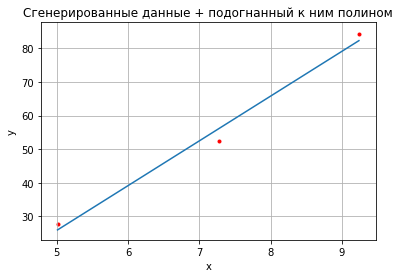

(7.4721405036036463, 204.79940718014802)

In [68]:
POPULATION_SIZE = 10000
SAMPLE_SIZE = 3 # нулевая вариативность - достаточно данных для однозначного построения параболы
POLY_DEGREE = 1 # ненулевой детерминистский шум - используется прямая
NOISE       = 4 # ненулевой стохастический шум
experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE)

In [69]:
in_list, pop_list = [], []
for _ in range(100):
    e_in, e_pop = experiment(POPULATION_SIZE, SAMPLE_SIZE, POLY_DEGREE, NOISE, show_result=False)
    in_list.append(e_in)
    pop_list.append(e_pop)

print('\n','='*40, '\nMSE на тренировке\n\t  Среднее:', np.mean(in_list))
print('\tДисперсия:', np.var(in_list))
print('\tMin и max:', min(in_list), max(in_list))
print('\n','='*40, '\nMSE на популяции\n\t  Среднее:', np.mean(pop_list))
print('\tДисперсия:', np.var(pop_list))
print('\tMin и max:', min(pop_list), max(pop_list), '\n')


MSE на тренировке
	  Среднее: 11.7462357544
	Дисперсия: 360.764421376
	Min и max: 0.00114694711646 107.201958028

MSE на популяции
	  Среднее: 232.869539543
	Дисперсия: 79739.9248245
	Min и max: 61.028233652 1942.46629511 



Результат значительно улучшился: средняя MSE на популяции стала значительно меньше, и её максимум не превысил 2000, тогда как MSE при подгонке параболы исчислялась сотнями миллионов.

<br><br><hr>
## Playground